In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import time
import gc
from tqdm import tqdm

In [2]:
st = time.time()
df = pd.read_csv('./new_feature_by_kageyama_feature_matrix.csv')
time.time() - st

137.8480851650238

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_feats = [f for f in df.columns if df[f].dtype == 'object']
for col in tqdm(categorical_feats):
    if col == 'set' :
        continue
    df[col] = df[col].astype('str')
    le.fit(df[col])
    df[col] = le.transform(df[col])
train_df = df.loc[df['set'] == 'train'] .drop('set', axis = 1)
test_df = df.loc[df['set'] == 'test'] .drop(['set', 'TARGET'], axis=1)

del df
gc.collect()

100%|██████████| 39/39 [00:43<00:00,  1.11s/it]


36

In [4]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(test_df.shape[0])

feature_importance_df = pd.DataFrame()
y = train_df['TARGET'].copy()
X = train_df.drop('TARGET', axis = 1)


feats =  list(X.columns)

folds = KFold(n_splits=25, shuffle=True, random_state=2018)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X)):
    train_X, train_y = X.iloc[trn_idx], y.iloc[trn_idx]
    valid_X, valid_y = X.iloc[val_idx], y.iloc[val_idx]

    clf = LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )

    clf.fit(train_X, train_y, 
            eval_set= [(train_X, train_y), (valid_X, valid_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )

    oof_preds[val_idx] = clf.predict_proba(valid_X, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[val_idx])))
    del clf, train_X, train_y, valid_X, valid_y
    gc.collect()

print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

sub = pd.read_csv('../input/sample_submission.csv')
sub['TARGET'] = sub_preds



Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.768614	valid_1's auc: 0.756425
[200]	training's auc: 0.797527	valid_1's auc: 0.772303
[300]	training's auc: 0.81557	valid_1's auc: 0.779338
[400]	training's auc: 0.829655	valid_1's auc: 0.782852
[500]	training's auc: 0.841568	valid_1's auc: 0.78506
[600]	training's auc: 0.852178	valid_1's auc: 0.786162
[700]	training's auc: 0.861959	valid_1's auc: 0.786971
[800]	training's auc: 0.870667	valid_1's auc: 0.787623
[900]	training's auc: 0.878691	valid_1's auc: 0.788287
[1000]	training's auc: 0.886101	valid_1's auc: 0.788538
Early stopping, best iteration is:
[959]	training's auc: 0.883181	valid_1's auc: 0.788701
Fold  1 AUC : 0.788701
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.768516	valid_1's auc: 0.754725
[200]	training's auc: 0.797277	valid_1's auc: 0.773639
[300]	training's auc: 0.815636	valid_1's auc: 0.781956
[400]	training's auc: 0.829428	valid_1's auc: 0

[300]	training's auc: 0.815567	valid_1's auc: 0.792359
[400]	training's auc: 0.829198	valid_1's auc: 0.796596
[500]	training's auc: 0.841446	valid_1's auc: 0.799325
[600]	training's auc: 0.851994	valid_1's auc: 0.800548
[700]	training's auc: 0.861835	valid_1's auc: 0.80083
[800]	training's auc: 0.87049	valid_1's auc: 0.801852
[900]	training's auc: 0.878576	valid_1's auc: 0.802206
Early stopping, best iteration is:
[856]	training's auc: 0.875161	valid_1's auc: 0.802491
Fold 12 AUC : 0.802491
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.769342	valid_1's auc: 0.746854
[200]	training's auc: 0.797728	valid_1's auc: 0.765976
[300]	training's auc: 0.816046	valid_1's auc: 0.774847
[400]	training's auc: 0.829986	valid_1's auc: 0.778664
[500]	training's auc: 0.841995	valid_1's auc: 0.780638
[600]	training's auc: 0.852426	valid_1's auc: 0.781915
[700]	training's auc: 0.862256	valid_1's auc: 0.783018
[800]	training's auc: 0.871113	valid_1's auc: 0.784255
[

[200]	training's auc: 0.797398	valid_1's auc: 0.773484
[300]	training's auc: 0.815299	valid_1's auc: 0.781706
[400]	training's auc: 0.829343	valid_1's auc: 0.784982
[500]	training's auc: 0.841361	valid_1's auc: 0.786252
[600]	training's auc: 0.852052	valid_1's auc: 0.787613
[700]	training's auc: 0.861544	valid_1's auc: 0.788131
[800]	training's auc: 0.870376	valid_1's auc: 0.788511
Early stopping, best iteration is:
[760]	training's auc: 0.866899	valid_1's auc: 0.7887
Fold 24 AUC : 0.788700
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.768616	valid_1's auc: 0.754412
[200]	training's auc: 0.796871	valid_1's auc: 0.777835
[300]	training's auc: 0.814872	valid_1's auc: 0.787244
[400]	training's auc: 0.829028	valid_1's auc: 0.791101
[500]	training's auc: 0.840939	valid_1's auc: 0.793317
[600]	training's auc: 0.851996	valid_1's auc: 0.794553
[700]	training's auc: 0.861718	valid_1's auc: 0.795412
[800]	training's auc: 0.8706	valid_1's auc: 0.795819
[90

In [5]:
sub.to_csv('./kageyama_feature_matrix_25cv_sub.csv', index=None)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()


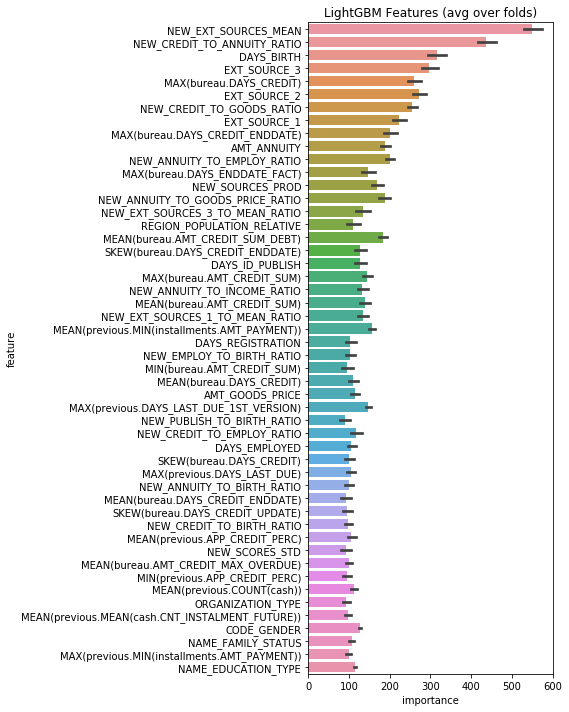

In [7]:
display_importances(feature_importance_df)

In [8]:
time.time() - st

11571.580299139023